# Housekeeping and Preprocessing

In [120]:
import pandas as pd
import numpy as np
from datetime import datetime

# Configure matplotlib plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

if 'WORKDIR' not in dir():
    WORKDIR = 'C:/Users/thewr/git/mit_data_science.git/'
data_proc_file = WORKDIR + '/Data/Processed/energy_consumption_data_modeling.parquet'

# Exploratory Data Analysis

We need to first check a few things:
1. Duplicate and missing data, as well as spread
2. How autocorrelated is this data and its seasonal decomposition

In [121]:
# Load my EDA helper function created to do some high-level analysis
class EDA():

    df = pd.DataFrame()
    
    def __init__(self, df):
        '''
        Creates EDA object for the DataFrame
        
        Note for time series data, have the index be the timestamp prior to creating this Object.
        
        :param df : DataFrame
        '''
        self.df = df
        
    def missing_values(self):
        '''
        Checks missing values
        
        :return DataFrame
        
        '''
        missing = self.df[self.df.isna().any(axis=1)]
        
        print("Missing values data")
        
        return missing
    
    def duplicate_values(self):
        duplicates = self.df[self.df.duplicated(subset=None, keep='first')==True]
        
        print("Duplicate values data")
        
        return duplicates
        
    def duplicate_indices(self):
        '''
        Check whether the indices have any duplicates
        
        :return DataFrame
        '''        
        duplicate_indices = self.df[self.df.index.duplicated()==True]
        
        print("Duplicate indices")
        
        return duplicate_indices
            
    def summary(self):
        '''
        Return summary/describe of DataFrame
        
        :return DataFrame
        '''
        df = self.df.reset_index() # Reset to include the index
        
        summary = df.describe(include='all').transpose()
        
        print("Summary metrics")
        
        return summary
    
    def pandas_profiling(self):
        import pandas_profiling
        
        self.df.profile_report(style={'full_width':True})  
    
    def histogram_KDE(self):
        ''' 
        :return seaborn plot
        '''       
        sns.pairplot(self.df, diag='kde')
        sns.distplot(kde=True, fit=[st.norm or st.lognorm])
        
    def outliers(self, col):
        ''' 
        Checks outliers - anything outside of 5% to 95% quartile range
        
        :param col : str
            Name of col to be tested
            
        :return DataFrame
        '''
        outliers = self.df[~self.df[col].between(self.df[col].quantile(.05), self.df[col].quantile(.95))]
        
        print("Outliers")
        
        return outliers
        
    def missing_timeseries_points(self, freq='D'):
        '''
        Checks whether there's any missing data points in continuous time series data.
        
        :param freq optional default = 'D' : str
            Frequency compliant with pandas formatting
        
        :return DataFrame
        '''
        # First create date range
        date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=freq)

        # Now compare against dataset
        missing_timeseries = self.df.index[~self.df.index.isin(date_range)]
        
        print("Missing timeseries data")
        
        return missing_timeseries

    def corr_heatmap(df):
        fig, ax = plt.subplots(figsize=(10, 6))
        corr = self.df.corr()
        hm = sns.heatmap(round(corr,2), annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
        fig.subplots_adjust(top=0.93)
        title = fig.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

        plt.show()

    def plot_time_series_seasonal_decomp(self, type='add'):
        '''
        Plots seasonal decomposition of timeseries data
        
        :return matplotlib Plot
        '''
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(self.df, model='multiplicative')

        fig = decomposition.plot()
        plt.show()
   
    def time_series_ADF(self):            
        '''
        Returns Augmented Dickey-Fuller Test
        '''
        from statsmodels.tsa.stattools import adfuller as ADF

        series = data['KwH'] # ADF takes series, not DF

        result = ADF(series)

        print('ADF Statistic: %f4.2' % result[0])
        print('P-value %f4.2' % result[1])

First let's have a look at the dataset - first few lines:

In [122]:
# Load the Data
data = pd.read_parquet(data_proc_file)

data.set_index('Datetime',inplace=True)

data.index = pd.to_datetime(data.index)

data_copy = data.copy(deep=True) # Make a deep copy, including a copy of the data and the indices
data.head(10)


PJME_MW
Datetime                    
2006-01-01 00:00:00  30293.0
2006-01-01 01:00:00  28884.0
2006-01-01 02:00:00  27556.0
2006-01-01 03:00:00  26484.0
2006-01-01 04:00:00  25822.0
2006-01-01 05:00:00  25530.0
2006-01-01 06:00:00  25768.0
2006-01-01 07:00:00  26364.0
2006-01-01 08:00:00  26865.0
2006-01-01 09:00:00  27619.0

Next let's have a look at some of the summary EDA data, missing values and duplicates:

In [123]:
eda_helper = EDA(data)

eda_helper.summary()

Summary metrics


count unique                 top freq      first                last  \
Datetime  8710   8710 2006-08-01 22:00:00    1 2006-01-01 2006-12-29 23:00:00   
PJME_MW   8710    NaN                 NaT  NaN        NaT                 NaT   

             mean      std    min    25%      50%    75%    max  
Datetime      NaN      NaN    NaN    NaN      NaN    NaN    NaN  
PJME_MW   32425.7  6597.22  19690  28016  31938.5  35368  62009

In [124]:
eda_helper.missing_values()

Missing values data


Empty DataFrame
Columns: [PJME_MW]
Index: []

In [125]:
eda_helper.duplicate_values()

Duplicate values data


PJME_MW
Datetime                    
2006-01-12 20:00:00  35874.0
2006-01-18 22:00:00  36612.0
2006-01-19 13:00:00  35506.0
2006-01-19 15:00:00  34204.0
2006-01-20 07:00:00  34065.0
...                      ...
2006-12-29 14:00:00  31985.0
2006-12-29 15:00:00  31337.0
2006-12-29 16:00:00  31197.0
2006-12-29 19:00:00  36728.0
2006-12-29 20:00:00  36168.0

[1600 rows x 1 columns]

In [126]:
eda_helper.duplicate_indices()

Duplicate indices


Empty DataFrame
Columns: [PJME_MW]
Index: []

Next we'll process it so the data is at the hourly level:

In [127]:
def preprocess_data(df):
    # We have duplicates, so we need to de-duplicate it - grabbing first value that pops up for a time series
    df.sort_index()
    df = df.groupby(df.index).first()
    
    #Set freq to H
    df = df.asfreq('H')
    
    return df

In [128]:
data = preprocess_data(data)

data.index

DatetimeIndex(['2006-01-01 00:00:00', '2006-01-01 01:00:00',
               '2006-01-01 02:00:00', '2006-01-01 03:00:00',
               '2006-01-01 04:00:00', '2006-01-01 05:00:00',
               '2006-01-01 06:00:00', '2006-01-01 07:00:00',
               '2006-01-01 08:00:00', '2006-01-01 09:00:00',
               ...
               '2006-12-29 14:00:00', '2006-12-29 15:00:00',
               '2006-12-29 16:00:00', '2006-12-29 17:00:00',
               '2006-12-29 18:00:00', '2006-12-29 19:00:00',
               '2006-12-29 20:00:00', '2006-12-29 21:00:00',
               '2006-12-29 22:00:00', '2006-12-29 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=8712, freq='H')

After preprocessing and cleaning up the data, as well as making sure the frequency is at the hourly level, let's plot the data.

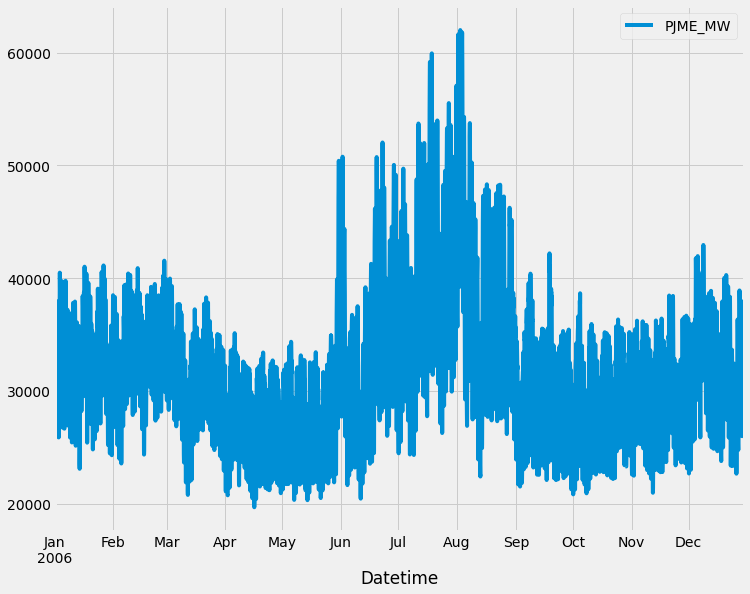

In [129]:
# Let's visualise the data
data.plot()

plt.show()

You can see because the frequency is at the hourly level, this is will make forecasting difficult (and its also difficult to visualise too!)

So what we will do is resample it and aggregate it to the daily level

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8712 entries, 2006-01-01 00:00:00 to 2006-12-29 23:00:00
Freq: H
Data columns (total 1 columns):
PJME_MW    8710 non-null float64
dtypes: float64(1)
memory usage: 136.1 KB


In [131]:
from datetime import datetime, timedelta
dataset_max_date  = pd.to_datetime('2006-03-26 00:00:00', format='%Y-%m-%d')
dataset_min_date = dataset_max_date - timedelta(days = 30)

In [132]:
#30 days will be considered to forecast 5 days ahead 
data_used = data[dataset_min_date:dataset_max_date]

In [133]:
data_used.tail()

PJME_MW
Datetime                    
2006-03-25 20:00:00  32353.0
2006-03-25 21:00:00  31744.0
2006-03-25 22:00:00  30690.0
2006-03-25 23:00:00  29235.0
2006-03-26 00:00:00  27408.0

**Seasonal Decomposition**

At a high-level, time series data can be thought of as components put together. That is:

**Data = Level + Trend + Seasonality + Noise**

* **Level**: the average value in the series.
* **Trend**: the increasing or decreasing value in the series.
* **Seasonality**: the repeating short-term cycle in the series.
* **Noise/Residual**: the random variation in the series.

Using the Python statsmodel library, the above components can be 'decomposed' (ie seasonal decomposition):

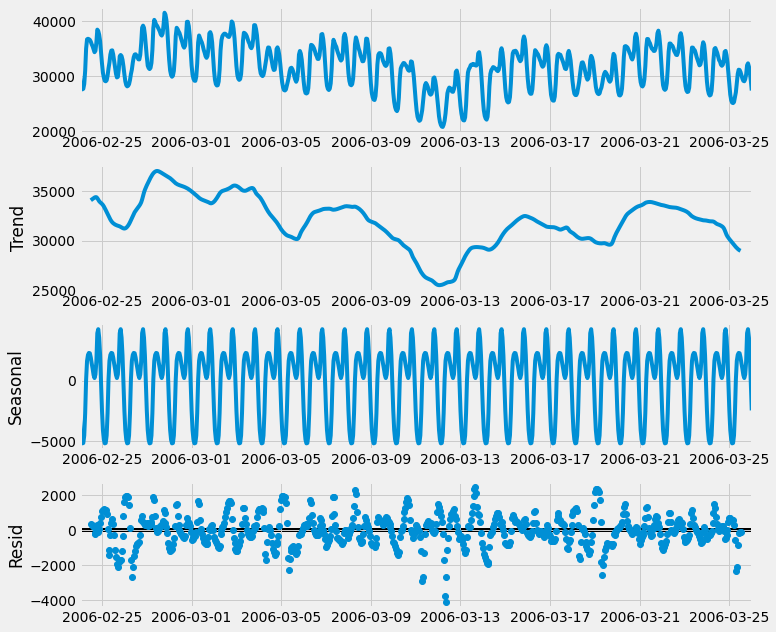

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_used, model='additive')

fig = decomposition.plot()
plt.show()

One thing that jumps out right now is very difficult to see what's going on, as the graph is very 'packed together'.

More 'traditional' econometric/statistical models, such as Holtwinters and SARIMA, require 3 characteristics for them to work properly, namely:

* Seasonality: the dataset is cyclical in nature
* Stationarity: the properties of the dataset doesn't change over time
* Autocorrelation: there is similiar between current and past (ie 'lagged') data points



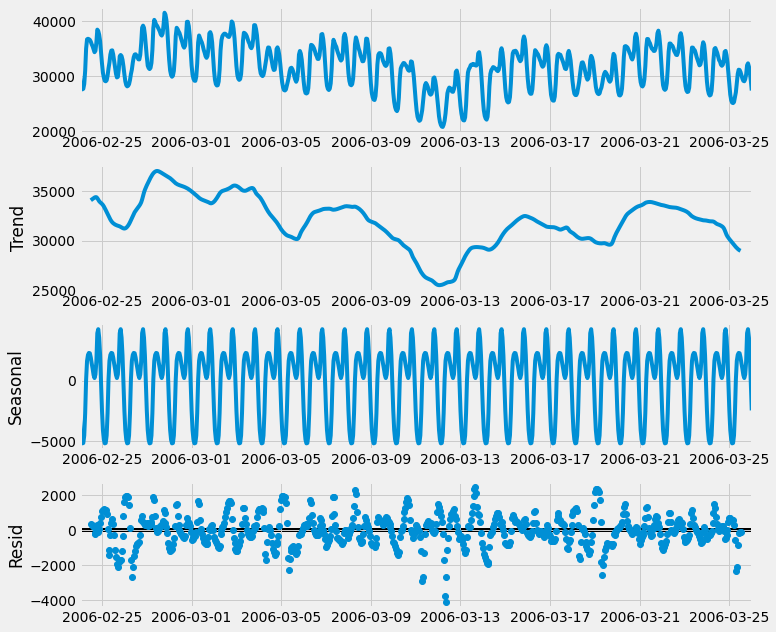

In [135]:
from statsmodels.tsa.seasonal import seasonal_decompose
daily_data = data_used.resample(rule='H').sum()
decomposition = seasonal_decompose(daily_data, model='additive') 

fig = decomposition.plot()
plt.show()

You can see start to see a pattern - electricity usage peak and troughs seem to be very seasonal and repetitive. This makes sense, considering office hours, weather patterns, shopping holidays etc.

Furthermore, you can see the trend of the data seems to be trailing downwards in the last few years.

Another way to visualise seasonality is to use a heatmap - we can base it on a week to see which days have higher electricity usage.

First let's construct the dataframe table.

In [136]:
# Create new dataset for heatmap
heatmap_data = data_used.copy()

# First we need to add weekdays as a column
heatmap_data['Weekday_Name'] = data_used.index.weekday_name

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='PJME_MW')

# Reorder columns
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head(100)

Weekday_Name     Monday    Tuesday  Wednesday   Thursday     Friday  \
Year                                                                  
2006          3166007.0  3167459.0  3183787.0  3132377.0  3873814.0   

Weekday_Name   Saturday     Sunday  
Year                                
2006          3598023.0  2878319.0

Then we visualise it:

Text(0.5, 1.0, 'Heatmap - by Day of Week')

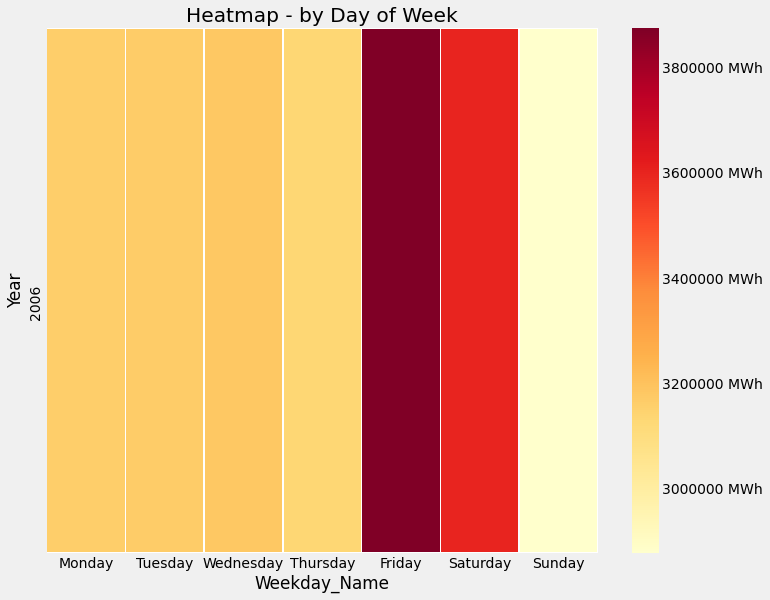

In [137]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Day of Week')

So using this you can see (as expected) the weekend has lower electricity use. Many businesses are closed during weekends and therefore this makes sense.

Now let's do the same thing but over the hours of a day (to sort of see peak operating hours)

In [138]:
# Create new dataset for heatmap
heatmap_data = data_used.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = data_used.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='PJME_MW')

heatmap_data.head(100)



Hour        0         1         2         3         4         5         6   \
Year                                                                         
2006  912894.0  836557.0  812071.0  802814.0  803553.0  822057.0  877950.0   

Hour        7          8          9   ...        14        15        16  \
Year                                  ...                                 
2006  961731.0  1007724.0  1021899.0  ...  985731.0  970391.0  962880.0   

Hour        17         18         19         20         21         22  \
Year                                                                    
2006  971686.0  1003713.0  1072466.0  1081929.0  1060993.0  1017105.0   

Hour        23  
Year            
2006  948997.0  

[1 rows x 24 columns]

Text(0.5, 1.0, 'Heatmap - by Hour of Day')

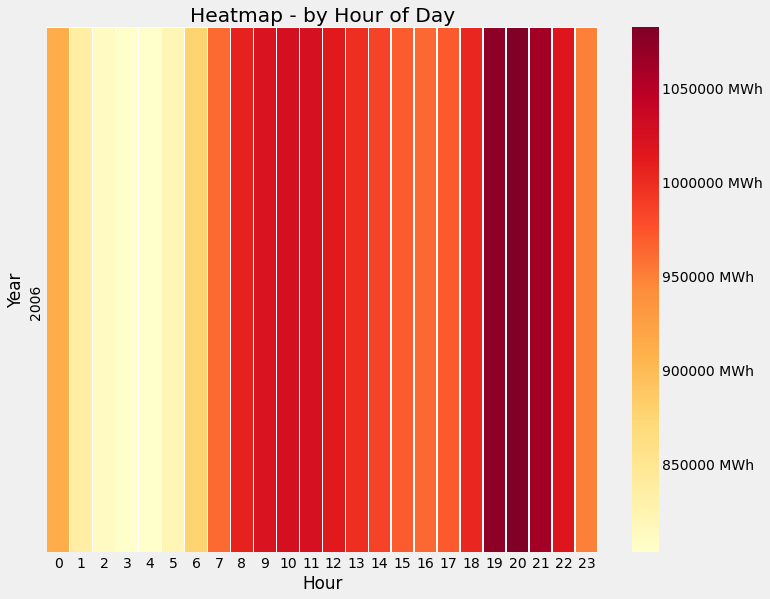

In [139]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Hour of Day')

Interestingly, it means 11am to 9pm is the busiest peak time of the grid.

# Statistical Test 'Smoke Alarms'

Statistical Tests are a good way to test whether the data is conductive to conventional statistical methods.

There are certain good statistical tests you can apply to a dataset as a 'smoke alarm' test. They are a good indication whether the data is conducive to accurate forecasting.

Both the below statistical tests use Hypothesis Testing and P-Values, which require a cutoff to be picked in advance. The general rule of thumb is 5% - which means there's a only a 5% chance of the statistical tests to be incorrect.

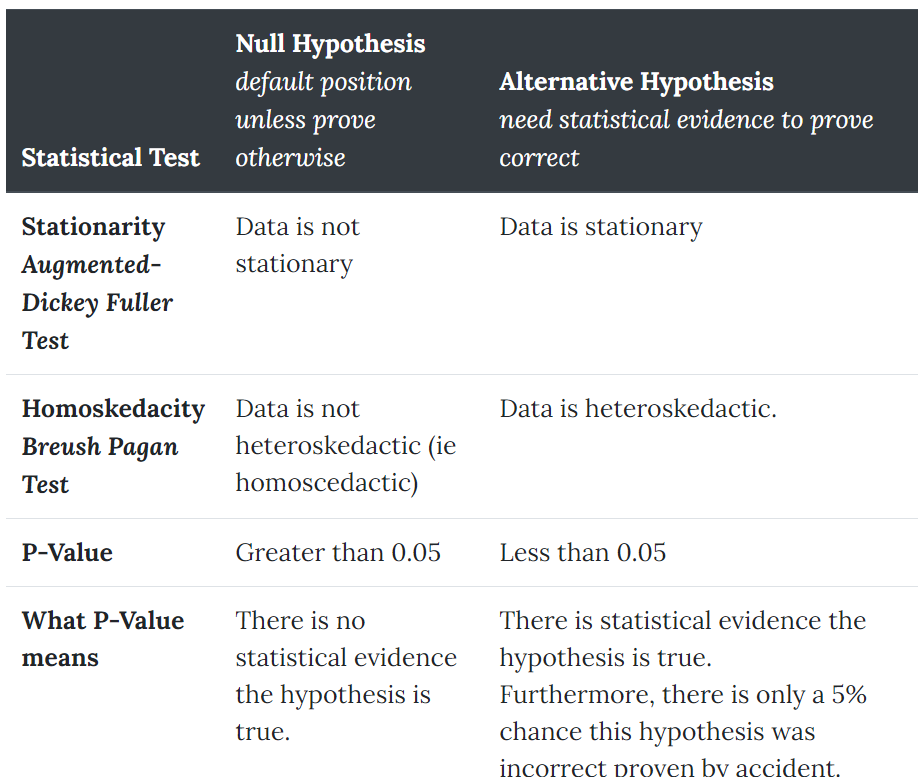


'**Stationary**' means the properties of the dataset don't change over time. Non-stationary means the trends, seasonality changes over time and the data is affected by factors other than the passsage of time. A Non-Stationary is sometimes known as a 'Random Walk' - which are notoriously difficult to forecast, because the underlying properties keep changing (e.g. like trying to hit a moving target).

Note that Random Walk is different to a set of 'random numbers' - it's random because the next point is based on a 'random' modification on the first point (e.g. add, minus, multiply). Whereas in a 'random numbers' set, ther would be little relationship between each data point.

So let's run the test for Stationarity and see the results: 

In [140]:
from statsmodels.tsa.stattools import adfuller as ADF

series = data_used['PJME_MW'] # ADF takes series, not DF

result = ADF(series)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic:  -4.474473127594059
P-value: 0.00021861323119103953


'**Heteroskedacity**' refers to instances where the data is evenly distributed along a regression line. Basically it means the data is more closely grouped together and therefore is less 'spiky' (ie has more peaks/troughs).

Heteroskedactic data means the peaks and troughs (ie outliers) are being observed way more often than a 'normally distributed' dataset. This means that a model will have a hard time predicting these spikes.

To alleviate this, heteroskedactic data generally needs to be Box-Cox/log transformed to dampen the extreme peaks/troughs. That is, bringing the data closer together so a model can better fit the whole data and hit the peaks/troughs.

So let's run the test for Heteroskedacity and see the results: 

In [141]:
from statsmodels.stats.diagnostic import het_breuschpagan as BP
import statsmodels.api as sm
from statsmodels.formula.api import ols

bp_data = data_used.copy()
bp_data['Time_Period'] = range(1, len(bp_data)+1) # Convert time series points into consecutive ints

formula = 'PJME_MW ~ Time_Period' # ie PJME MW depends on Time Period (OLS auto adds Y intercept)

# Next we apply Ordinary Linear Square baseline regression model - as baseline test
model = ols(formula, bp_data).fit()

result = BP(model.resid, model.model.exog)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic:  0.08118830047518544
P-value: 0.77569347530955934378


In our case, we got the above results which means:
* The data is **Stationary** (as the P-Value was below 0.05)
* The data is not **heteroskedactic** (as the P-Value was not below 0.05)


# Autocorrelation
Autocorrelation is basically how much correlation there is between a particular time point and a prior one - e.g. today's value is highly correleated with last week's value.

Again, Python Statsmodel has a great Autocorrelation Function (ACF) that easily produces this:

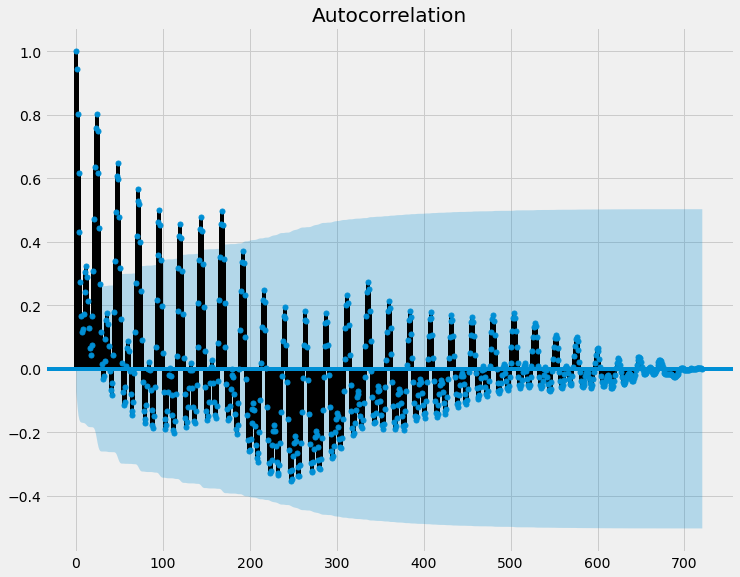

In [142]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#fig, ax = plt.subplots(2,1)

# Plot the acf function
plot_acf(data_used['PJME_MW'],lags=720) #alpha 1 suppresses CI

plt.show()

What the above graph shows is how correlated a prior point is to the current point. The further the number is away from 0, the more correlation there is.

Generally, we would only consider any points above (for positive numbers) and below (for negative numbers) the blue shaded area (the confidence interval) as statistically significant and worth noting.

This shows that yesterday's value has a very high correlation with today's value and it's a bit difficult noting some seasonality because of the short period of 30 days.

Another modification of this autocorrelation analysis is the Partial Autocorrelation Function (PACF). This function is a variant of ACF, as it finds correlation of the residuals, after removing the effects which are already explained in earlier lags. That way, you don't get a 'compounding' correlation effect.

This graph shows that the last 30 days have a stronger correlation, but the effect becomes much less obvious the further back you go.

C:\Users\thewr\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


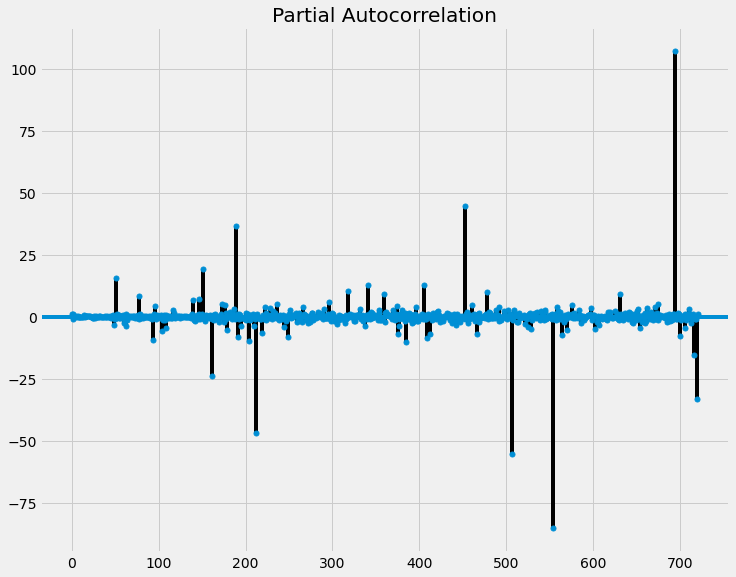

In [143]:
plot_pacf(data_used['PJME_MW'],lags=720) #alpha 1 suppress CI

plt.show()

# Train Test Split 
Before we continue, let us split the data up between train and split with a specified cutoff date.

Let's divide the data in 80% train and 20% test

In [144]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
split_date = data_used.iloc[int(data_used.shape[0] * 0.80)]
print(split_date)
cutoff = '2006-03-20 00:00:00'

data_used.sort_index()

train = data_used[:cutoff]
test = data_used[cutoff:]

PJME_MW    28525.0
Name: 2006-03-20 00:00:00, dtype: float64


In [145]:
train.index.min()

Timestamp('2006-02-24 00:00:00')

In [146]:
train.index.max()

Timestamp('2006-03-20 00:00:00')

In [147]:
test.index.min()

Timestamp('2006-03-20 00:00:00')

In [148]:
test.index.max()

Timestamp('2006-03-26 00:00:00')

# 1. Holtwinters Triple Exponential Smoothing
Next we will use a time series forecasting model that takes advantage of the above identified components.

This is known as a 'generative additive model', as the final forecast value is 'adding' together multiple components.

The 'Triple' refers to the three components:
1. **Level**
2. **Trend**
3. **Seasonality**

Holtwinters works really well when the data is seasonal and has trends.

'Smoothing' basically means more weight is put on more recent data compared to the past.

Note the main hyperparameters for the model are:
* **Additive vs Multiplicative **(ie 'add' or 'mul') 
* **Box Cox** - to use box cox log transformation to reduce the 'noise' of the data
* **Alpha** - smoothing factor between 0 and 1. 1 means will always take yesterday's value (naive forecasting). 0 means take simple average of past.

Additive means the formula looks more like this: Data = Level + Trend + Seasonality

Multiplicative means the formula looks more like this: Data = Level x Trend x Seasonality

We are using Box-Cox as heteroskedatic test before showed data requires dampening to reduce extremes.

In [185]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First we split it up between train and test
htrain = train['PJME_MW'] # HWES takes series, not DF
htest = test['PJME_MW'] # HWES takes series, not DF

model = ExponentialSmoothing(
    htrain
    ,trend='add'
    ,seasonal='add'
    ,freq='H'    
    ,seasonal_periods=168 #Default is auto estimated - 4 is quarterly and 7 is weekly
).fit(
    optimized=True # Default is True - auto estimates the other parameters using Grid Search
    ,use_basinhopping=True # Uses Basin Hopping Algorithm for optimising parameters
    ,use_boxcox='log' #Boxcox transformation via log
    #,smoothing_level= # Alpha
    #,smoothing_slope= # Beta
    #,smoothing_seasonal= # Gamma
)

HWES_prediction = model.predict(start=htest.index[0], end=htest.index[-1])
HWES_prediction = HWES_prediction.to_frame().rename(columns={0: 'PJME_MW'})

print("Finished training and predicting")

# Let's see what the model did
model.summary()

Finished training and predicting


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    endog   No. Observations:                  577
Model:             ExponentialSmoothing   SSE                       39562471.392
Optimized:                         True   AIC                           6769.212
Trend:                         Additive   BIC                           7518.761
Seasonal:                      Additive   AICC                          6920.704
Seasonal Periods:                   168   Date:                 Thu, 10 Sep 2020
Box-Cox:                           True   Time:                         12:43:21
Box-Cox Coeff.:                     log                                         
==================================================================================
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9473686                alpha                 True
smoothing_slope                0.7368421                 beta                 True
smoothing_seasonal             0.0526355                gamma                 True
initial_level                  10.293298                  l.0                 True
initial_slope                   0.000000                  b.0                 True
initial_seasons.0              0.0439834                  s.0                 True
initial_seasons.1             -0.0209752                  s.1                 True
initial_seasons.2             -0.0563070                  s.2                 True
initial_seasons.3             -0.0669667                  s.3                 True
initial_seasons.4             -0.0631364                  s.4                 True
initial_seasons.5             -0.0319616                  s.5                 True
initial_seasons.6              0.0488959                  s.6                 True
initial_seasons.7              0.1704330                  s.7                 True
initial_seasons.8              0.2179964                  s.8                 True
initial_seasons.9              0.2204710                  s.9                 True
initial_seasons.10             0.2186223                 s.10                 True
initial_seasons.11             0.2150516                 s.11                 True
initial_seasons.12             0.2064399                 s.12                 True
initial_seasons.13             0.1926841                 s.13                 True
initial_seasons.14             0.1821570                 s.14                 True
initial_seasons.15             0.1669149                 s.15                 True
initial_seasons.16             0.1520196                 s.16                 True
initial_seasons.17             0.1594666                 s.17                 True
initial_seasons.18             0.2019670                 s.18                 True
initial_seasons.19             0.2646991                 s.19                 True
initial_seasons.20             0.2580259                 s.20                 True
initial_seasons.21             0.2402900                 s.21                 True
initial_seasons.22             0.2083662                 s.22                 True
initial_seasons.23             0.1509134                 s.23                 True
initial_seasons.24             0.0907309                 s.24                 True
initial_seasons.25             0.0374159                 s.25                 True
initial_seasons.26             0.0073529                 s.26                 True
initial_seasons.27            -0.0118536                 s.27                 True
initial_seasons.28            -0.0153207                 s.28                 True
initial_seasons.29            -0.0092874                 s.29          

Using Holtwinters, data from 25 days was used to train the model, while the remaining 5 days data was used to test/evaluate the model's accuracy.

Training data is in blue, while test/evaluation data is in red.

Let's evaluate our model using Mean Absolute Error (MAE) and visualise the results

In [186]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE HWES ADD: {:.20f}".format(meanabs(htest, HWES_prediction['PJME_MW'])))

MAE HWES ADD: 15174.04163039096965803765


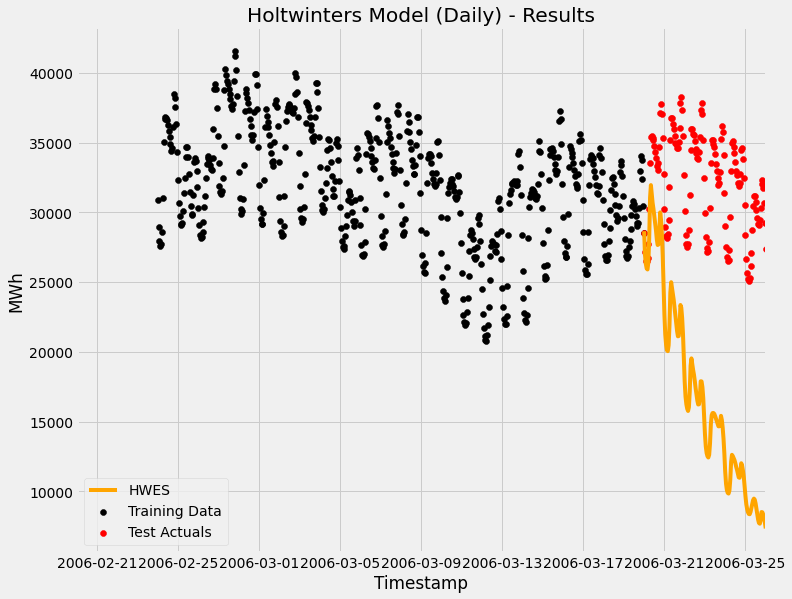

In [187]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(HWES_prediction['PJME_MW'], label='HWES', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Holtwinters Model (Daily) - Results')

# For clarify, let's limit to only about 3o days
plt.xlim(datetime(2006, 2, 20),datetime(2006, 3, 26))

plt.show()

So it seems Exponential Smoothing is a no-go - let's see how the others fare.

# LASSO (L1) Regression

LASSO regression incorporate regularisation and feature selection into its algorithm. Regularisation is a technique used in regression algorithms to avoid overfitting. For LASSO, this means it will penalise the 'irrelevant' features by effectively by 'zeroing' out those features (by multiplying it with a 0 coefficient). 

The main hyperparameter to tune is the penalty factor (i.e. lambda or alpha). A factor of 0 means no penalisation occurs, and it effectively just does an Ordinary-Least-Squares (OLS) regression.

Since we've already set up all the train-test split (as well as feature engineering) in the prior XGBoost model, we can just re-use it.

However, like the decision tree-based XGBoost, linear regression is sensitive to scale. Therefore, we also need to scale the data.

In [152]:
data_used.head()

PJME_MW
Datetime                    
2006-02-24 00:00:00  30862.0
2006-02-24 01:00:00  28921.0
2006-02-24 02:00:00  27917.0
2006-02-24 03:00:00  27621.0
2006-02-24 04:00:00  27727.0

In [153]:
xtrain = train.copy() 
xtest = test.copy() 

train_feature, train_label = preprocess_xgb_data(xtrain)
test_feature, test_label = preprocess_xgb_data(xtest)

In [154]:
# Feature Engineering first

def preprocess_xgb_data(df, lag_start=1, lag_end=720):
    '''
    Takes data and preprocesses for XGBoost.
    
    :param lag_start default 1 : int
        Lag window start - 1 indicates one-hour behind
    :param lag_end default 720 : int
        Lag window start - 720 indicates 30 days behind (24h * 30 days)
        
    Returns tuple : (data, target)
    '''
    # Default is add in lag of 720 hours of data - ie make the model consider 720 hours of prior data
    for i in range(lag_start,lag_end):
        df[f'PJME_MW {i}'] = df.shift(periods=i, freq='H')['PJME_MW']

    df.reset_index(inplace=True)

    # Split out attributes of timestamp - hopefully this lets the algorithm consider seasonality
    df['date_epoch'] = pd.to_numeric(df['Datetime']) # Easier for algorithm to consider consecutive integers, rather than timestamps
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['weekofyear'] = df['Datetime'].dt.weekofyear
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    
    x = df.drop(columns=['Datetime', 'PJME_MW']) #Don't need timestamp and target
    y = df['PJME_MW'] # Target prediction is the load
    
    return x, y


In [155]:
# So because we need the lag data, we need to preprocess then do the split
data_preprocessed = data_used.copy()

# Create train test dataset using XGBoost preprocessing (575 hours top 720 hours lag)
feature, label = preprocess_xgb_data(data_preprocessed, lag_start=575, lag_end=720)

# We will aim for a 5 days forecast horizon (ie predict the last 5 days in the dataset)
# 576 = 5 days * 24 hours. Corresponds to the point where the data is splitted into 2 sets. 
train_feature = feature[:576]
train_label = label[:576]

test_feature = feature[576:]
test_label = label[576:]

train_feature = train_feature.fillna(0)
test_feature = test_feature.fillna(0)

train_feature.drop(columns=['date_epoch']) #Don't need timestamp
test_feature.drop(columns=['date_epoch']) #Don't need timestamp

# Scale dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_feature_scaled = scaler.fit_transform(train_feature)
test_feature_scaled = scaler.transform(test_feature)

In [191]:
print(test_feature)

     PJME_MW 575  PJME_MW 576  PJME_MW 577  PJME_MW 578  PJME_MW 579  \
576      28921.0      30862.0          0.0          0.0          0.0   
577      27917.0      28921.0      30862.0          0.0          0.0   
578      27621.0      27917.0      28921.0      30862.0          0.0   
579      27727.0      27621.0      27917.0      28921.0      30862.0   
580      28605.0      27727.0      27621.0      27917.0      28921.0   
..           ...          ...          ...          ...          ...   
716      37550.0      38029.0      37796.0      35034.0      33677.0   
717      36170.0      37550.0      38029.0      37796.0      35034.0   
718      33649.0      36170.0      37550.0      38029.0      37796.0   
719      31090.0      33649.0      36170.0      37550.0      38029.0   
720      29392.0      31090.0      33649.0      36170.0      37550.0   

     PJME_MW 580  PJME_MW 581  PJME_MW 582  PJME_MW 583  PJME_MW 584  ...  \
576          0.0          0.0          0.0          0.0   

Next we'll train the model using sklearn's time series split cross validation method.

In this case, we'll create a 5-fold split.

In [156]:
# Create Time Series k-fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=100) # in this case 5-fold

#Train and predict using LASSO
from sklearn.linear_model import LassoCV

model = LassoCV(
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1]    
    ,max_iter=20000 # 1000 iterations
    ,random_state=42
    ,cv=tscv
    ,verbose=True
)
model.fit(
    train_feature_scaled
    ,train_label
)
LASSO_prediction = xtest.copy()
LASSO_prediction['PJME_MW Prediction'] = model.predict(test_feature_scaled)
LASSO_prediction = LASSO_prediction[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')
LASSO_prediction = LASSO_prediction.rename(columns={'PJME_MW Prediction': 'PJME_MW'})

LASSO_prediction

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

PJME_MW
Datetime                         
2006-03-20 00:00:00  26376.843089
2006-03-20 01:00:00  26710.820267
2006-03-20 02:00:00  27026.959822
2006-03-20 03:00:00  27332.971233
2006-03-20 04:00:00  27619.532579
...                           ...
2006-03-25 20:00:00  28582.798939
2006-03-25 21:00:00  28926.249206
2006-03-25 22:00:00  29298.446268
2006-03-25 23:00:00  29671.600715
2006-03-26 00:00:00  21864.637984

[145 rows x 1 columns]

Now let's plot the results

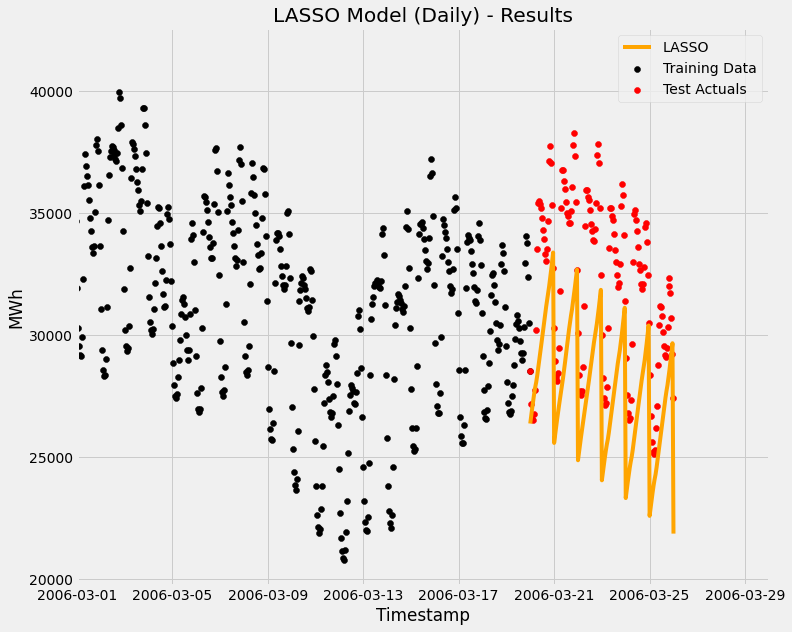

In [157]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(LASSO_prediction, label='LASSO', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('LASSO Model (Daily) - Results')
plt.tight_layout()
plt.grid(True)


# For clarify, let's limit to only about 30 days
plt.xlim(datetime(2006, 3, 1),datetime(2006, 3, 30))         

plt.show()

Next let's see feature importance by way of coefficients - we'll only get Top 10.

Remember, LASSO will 'zero-out' irrelevant features, so in this case, these are the Top 10 features that LASSO considers are most important.

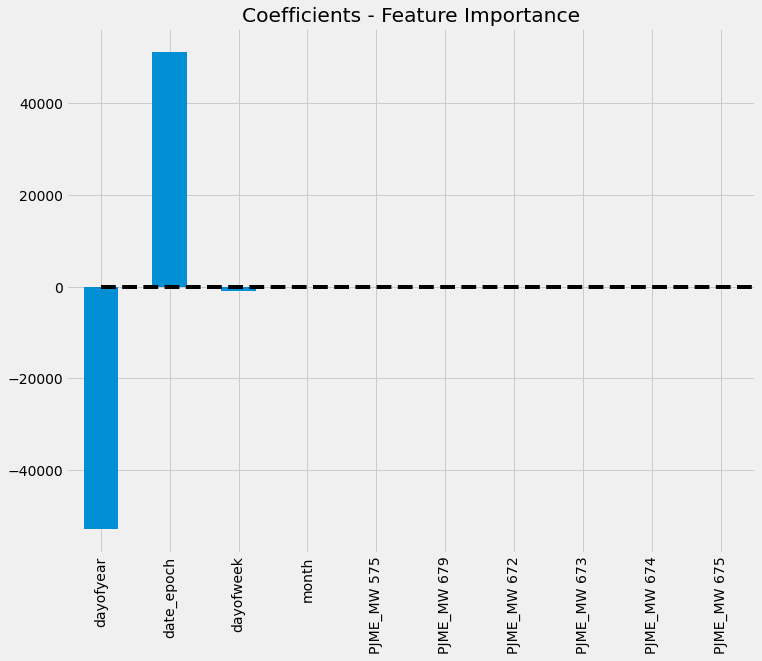

In [158]:
# Plot feature importance by way of coefficients    

# Create DataFrame
coefs = pd.DataFrame(model.coef_, train_feature.columns)
coefs.columns = ["coef"]

# Only grab the Top 10 Coefficients
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).head(10)
coefs = coefs.drop(["abs"], axis=1)

# Plot
coefs.coef.plot(kind='bar')

# Plot title and x-axis line
plt.title("Coefficients - Feature Importance")
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

So LASSO is producing half decent results! Now let's have a look at the residuals/errors.

First let's look at the distribution of the errors - remember, the ideal state is the errors are centred around zero (meaning the model doesn't particularly over or under forecast in a biased way)

In [159]:
# First construct the residuals - basically the errors
lasso_errors = LASSO_prediction.copy()
lasso_errors['PJME_MW_ACTUAL'] = test.copy()
lasso_errors['error'] = lasso_errors['PJME_MW'] - lasso_errors['PJME_MW_ACTUAL']

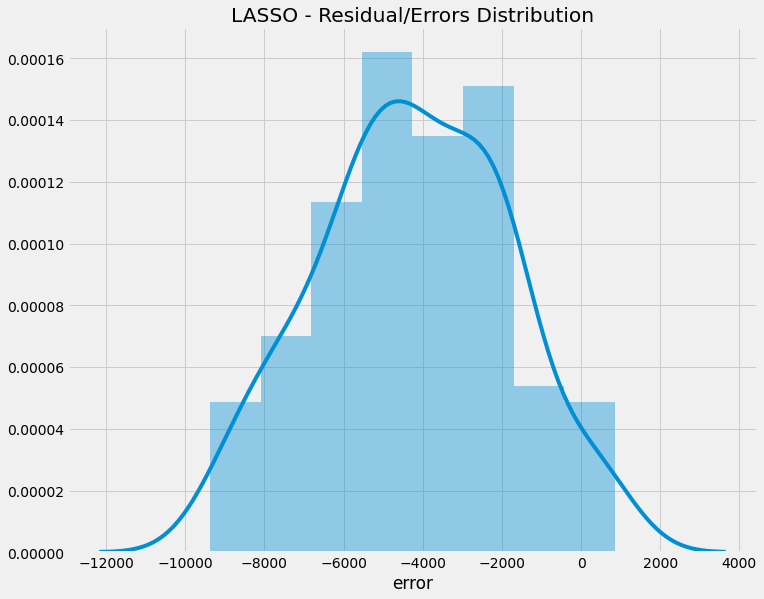

In [160]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(lasso_errors['error'], kde=True)

# Plot Labels, Legends etc
plt.title('LASSO - Residual/Errors Distribution')

plt.show()

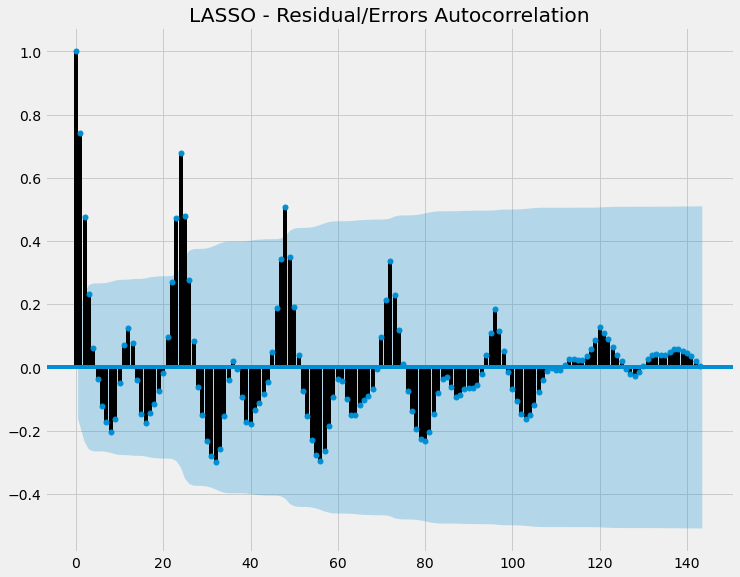

In [161]:
# Plot the acf function
plot_acf(lasso_errors['error'],lags=143) #alpha 1 suppresses CI

plt.title('LASSO - Residual/Errors Autocorrelation')
plt.show()

# SARIMA

The conventional ARIMA model assumes that the historical data are useful to predict the value at the next time step. In this case, this is somewhat true, as the ACF plot before showed past value is somewhat correlated with today's value.

ARIMA basically integrates two naive forecasting techniques together:

1. **Autoregression** - Uses one or more past values to forecast the future. The number of values used is known as the 'order' (e.g. order 2 means yesterday and day before's value is used)

2. **Integrating** - the part that reduces seasonality. How many degrees of differencing is done to reduce seasonality is the 'order'.

3. **Moving Average** - Uses the Moving Average of the historical data to adjust the forecasted values. This has a 'smoothing' effect on the past data, as it uses the moving average rather than the actual values of the past. The number of days in the moving average window is the 'order'.

SARIMA then adds a '**seasonality**' flavour to the ARIMA model - it factors in trends and seasonality, as explained above.

The main hyperparameters are SARIMAX(p,d,q)(P,D,Q,m):
1. autoregression order (p)
2. Integrating order (d)
3. moving average window (q)
4. Seasonal autoregressive order (P)
5. Seasonal difference order (D)
6. Seasonal moving average order (Q)
7. number of time steps for a single seasonal period (m)

The X is the exogenous (external) variables to the model - they are optional and for this model we won't use them.

Like Holtwinters, the training and testing data was splitted. 

The results were as follows:


In [163]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import meanabs

# Equivalent to R's Auto ARIMA to get the optimal parameters
#import pmdarima as pm
#model = pm.auto_arima(htrain, seasonal=True, stationary=True, stepwise=True, trace=True, suppress_warnings=True)

# First we split it up between train and test
htrain = train['PJME_MW'] # SARIMAX takes series, not DF
htest = test['PJME_MW'] # SARIMAX takes series, not DF

# Next define hyperparameters. Default is AR model (1,0,0)(0,0,0,0)
p = 1 # AR order
d = 0 # I degree
q = 1 # MA window
P = 0 # AR seasonal order
D = 1 # I seasonal order
Q = 2 # MA seasonal order
m = 6 # Seasonality period length

model = SARIMAX(
    htrain,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m)
    ,enforce_stationarity=False
    ,enforce_invertibility=False
).fit(
    maxiter=50 # Default is 50
)

results = model.get_prediction(start=htest.index.min(), end=htest.index.max(), dynamic=False)
SARIMA_prediction_CI = results.conf_int(alpha=(1-0.8)) # 80% CI
SARIMA_prediction = results.predicted_mean
SARIMA_prediction = SARIMA_prediction.to_frame().rename(columns={0: 'PJME_MW'})

# Evaluate it's performance using Mean Absolute Error (MAE)
print("Finished training and predicting. MAE SARIMA: {:.20f}. AIC: {}. Parameters: p,d,q,P,D,Q,m: ".format(meanabs(htest, SARIMA_prediction['PJME_MW']), model.aic), p,d,q,P,D,Q,m)

Finished training and predicting. MAE SARIMA: 3644.15506025305285220384. AIC: 9142.974387242888. Parameters: p,d,q,P,D,Q,m:  1 0 1 0 1 2 6


C:\Users\thewr\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


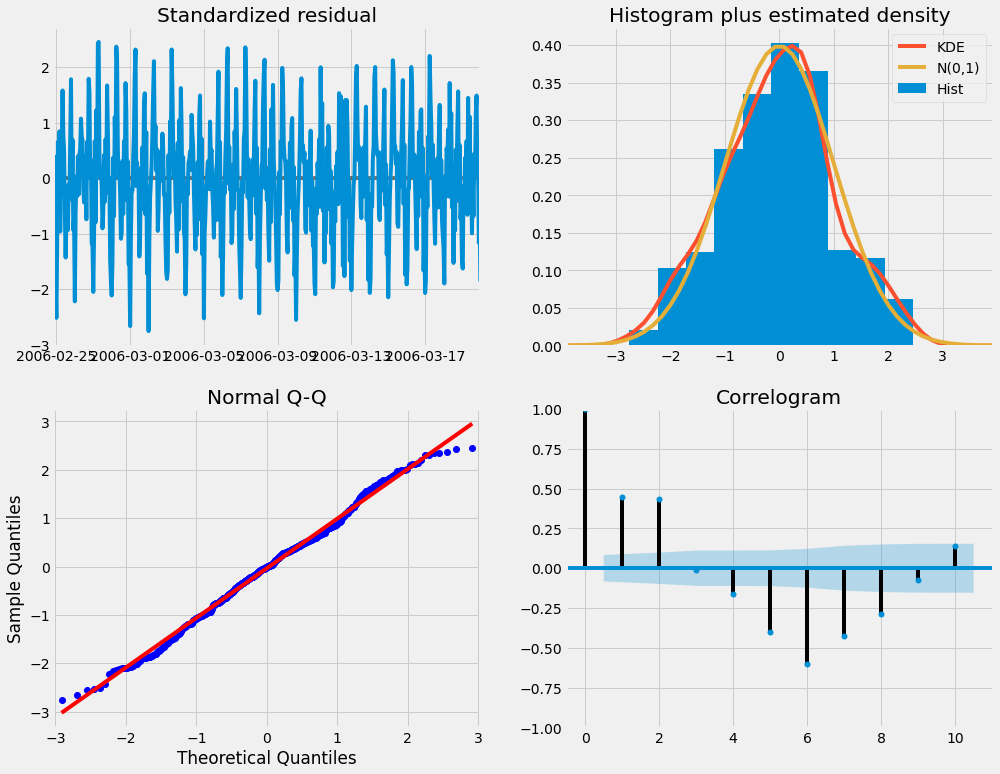

In [164]:
# Let's see what the model did
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Importantly, the model should have the residuals uncorrelated and normally distributed (ie the mean should be zero). That is the, the centre point of the residuals should be zero and the distribution plot (KDE) should also be centred on 0.

Let's evaluate the results and visualise it.

In [165]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE SARIMA: {:.20f}".format(meanabs(htest, SARIMA_prediction['PJME_MW'])))

MAE SARIMA: 3644.15506025305285220384


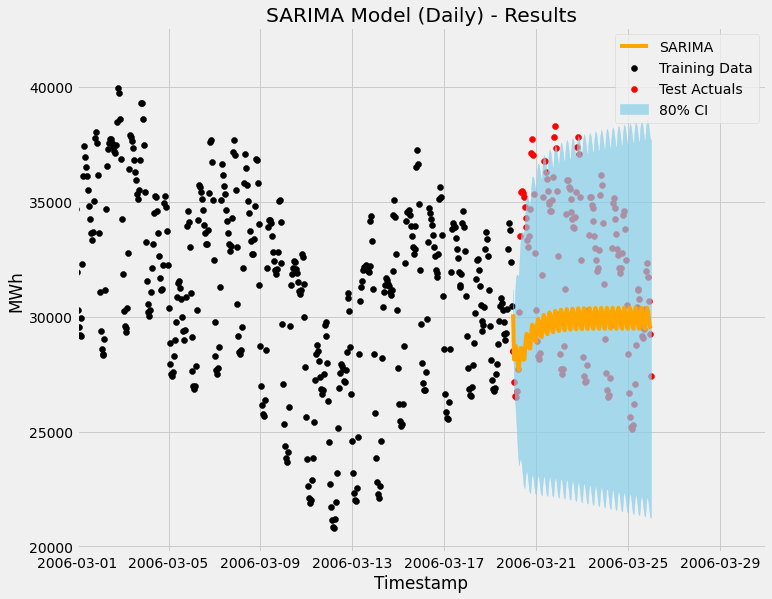

In [166]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(SARIMA_prediction['PJME_MW'], label='SARIMA', color='orange')

# Plot Confidence Interval
plt.fill_between(
    SARIMA_prediction.index,
    SARIMA_prediction_CI['lower PJME_MW'],
    SARIMA_prediction_CI['upper PJME_MW'],
    color='skyblue',
    alpha=0.7, # 70% transparency
    label='80% CI'
)

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('SARIMA Model (Daily) - Results')

# For clarify, let's limit to only about 30 days
plt.xlim(datetime(2006, 3, 1),datetime(2006, 3, 31))

plt.show()

So you can see that despite some tuning, the results are not particularly good. The confidence interval is very big, indicating the model has is not 'confident' in the prediction either.

# Prophet

Lastly, we will use Facebook Prophet - an open-source library that is also a generalised additive model (ie final result is made up of multiple components added together).

## It's all about probabilities!

Unlike regular Generalised Linear Models, Facebook Prophet's uses a Bayesian curve fitting approach. The concept of Bayesian theorem is, at high level, trying to determine the probability of related events given knowledge/assumptions you already know (ie 'priors').

This is basically fancy talk for saying it focuses on finding a bunch of possible parameters and the probability of each one rather than finding fixed optimal values for the model. How certain (or uncertain) the model is about each possible parameter is known as the 'uncertainty interval' - the less data the model sees, the bigger the interval is.

The sources of uncertainty that Prophet's Bayesian approach aims to address are:

* Uncertainty of the predicted value
* Uncertainty of the trend and trend changes
* Uncertainty of additional noise

## Trends, 'Changepoints' and Seasonality

Prophet is different to SARIMA and HoltWinters, as it essentially decomposes time series differently by:

**Data = Trend +/x Seasonality +/x Holidays +/x Noise**

In Prophet, trend represents non-periodic changes while seasonality represents periodic changes. Where it differs from other statistic models like SARIMA and Holtwinters is Prophet factors in the uncertainty of trends changing.

Interestingly, Prophet fits a curve to each component independently (ie fits a regression for each component with time as independent variable). That is:

Trend - fits piece-wise linear/log curve
Seasonality - uses fourier series
Holidays - uses constant/fixed values
Prophet reacts to changes in trends by 'changepoints' - that is sudden and abrupt changes in the trend. An example, is the release of a new electric car that will impact sale of petrol cars.

How 'reactive'/flexible Prophet is to changepoints will impact how much fluctation the model will do. For example, when the changepoint scale is to very high, it becomes very sensitive and any small changes to the trend will be picked up. Consequently, the sensitive model may detect spikes that won't amount to anything, while an insensitive model may miss spikes altogether.

The uncertainty of the predictions is determined by the number of changepoints and the flexibility of the changepoint allowed. In other words, if there were many changes in the past, there's likely going to be many changes in the future. Prophet gets the uncertainty by randomly sampling changepoints and seeing what happened before and after.

Furthermore, Prophet factors in seasonality by considering both its length (ie seasonal period) and its frequency (ie its 'fourier order').For example, if something keeps happening every week on Monday, the period is 7 days and its frequency is 52 times a year.

There's also a function for Prophet to consider additional factors (e.g. holidays), but for the purposes of this forecast we won't use it.


## Training
Prophet works quite well out of the box, so I just stuck with the default hyperparameters.

The results can be seen below, with the black dots representing historical points and the blue line representing the prediction:

In [167]:
from fbprophet import Prophet

ftrain = train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW': 'y'}) # Prophet takes ds and y as column names only

model = Prophet(
    n_changepoints=25 # Default is 25
    ,changepoint_prior_scale=0.05 # Default is 0.05
    ,seasonality_mode='additive'
    ,interval_width=0.8 # CI - default is 0.8 or 80%
)
model.fit(ftrain)

# Create the future dataframe with date range that will be used to test accuracy
future_df = test.reset_index()['Datetime'].to_frame().rename(columns={"Datetime":'ds'})

# Predict the future
forecast = model.predict(future_df)
PROPHET_prediction = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']][cutoff:]
PROPHET_prediction = PROPHET_prediction.rename(columns={'yhat': 'PJME_MW'})

print("Finished training and predicting")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Finished training and predicting


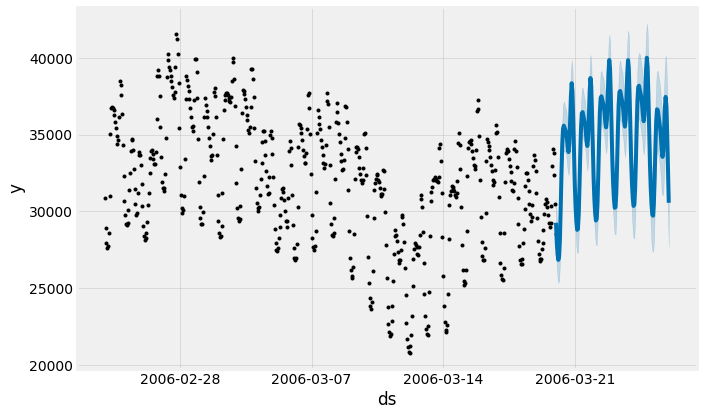

In [168]:
model.plot(forecast)

plt.show()

Let's zoom into the period and visualise it (with the consistent graph format as above):

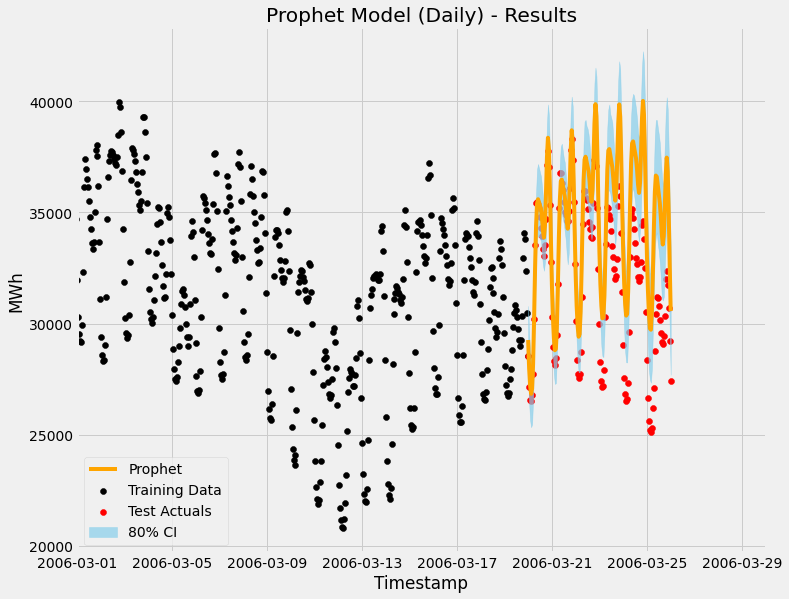

In [169]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(PROPHET_prediction['PJME_MW'], label='Prophet', color='orange')

# Plot Confidence Interval
plt.fill_between(
    PROPHET_prediction.index,
    PROPHET_prediction['yhat_lower'],
    PROPHET_prediction['yhat_upper'],
    color='skyblue',
    alpha=0.7, # 70% transparency
    label='80% CI'
)

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Prophet Model (Daily) - Results')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2006, 3, 1),datetime(2006, 3, 30))

plt.show()

You can see the 80% confidence interval (in light blue), indicating the model is confident that 80% of the actual data will land in that predicted range.

Like Holtwinters, let's see the components of the model:

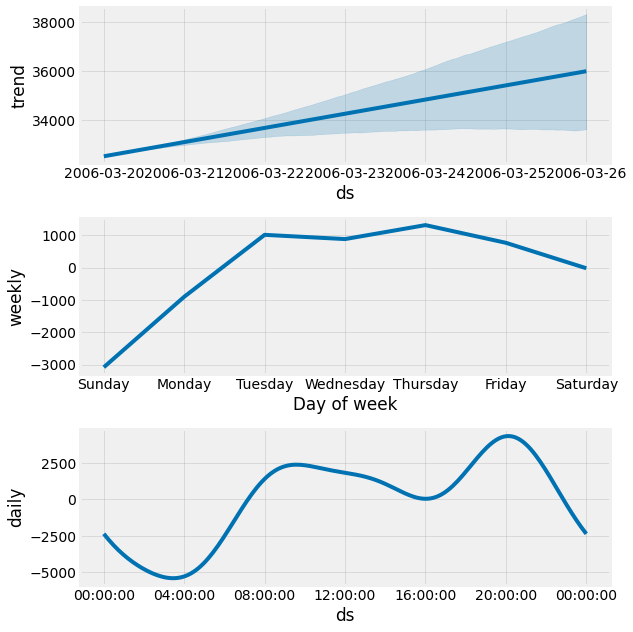

In [170]:
model.plot_components(forecast)

plt.show()

You can easily see the trends - there's a clear upward trend. Weekly seasonality if not quite clear. 

Now let's evaluate the residuals and see whether the model is biased in any way. First we'll look at the distribution of the errors:

In [171]:
# First construct the residuals - basically the errors
prophet_errors = PROPHET_prediction.copy()
prophet_errors['PJME_MW_ACTUAL'] = test['PJME_MW']
prophet_errors['error'] = prophet_errors['PJME_MW'] - prophet_errors['PJME_MW_ACTUAL']

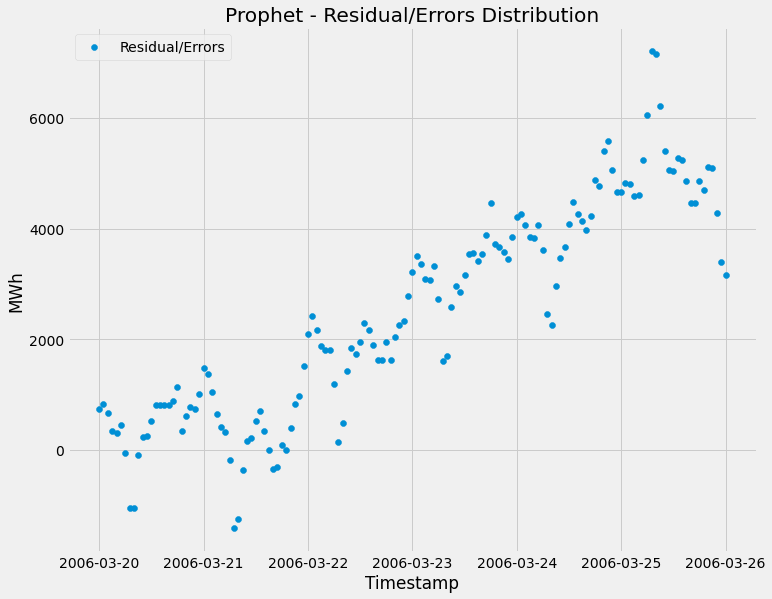

In [172]:
# Let's visually see the errors via scatterplot
plt.scatter(prophet_errors.index, prophet_errors['error'], label='Residual/Errors')

# Plot Labels, Legends etc
plt.title('Prophet - Residual/Errors Distribution')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Prophet - Residual/Errors Distribution')

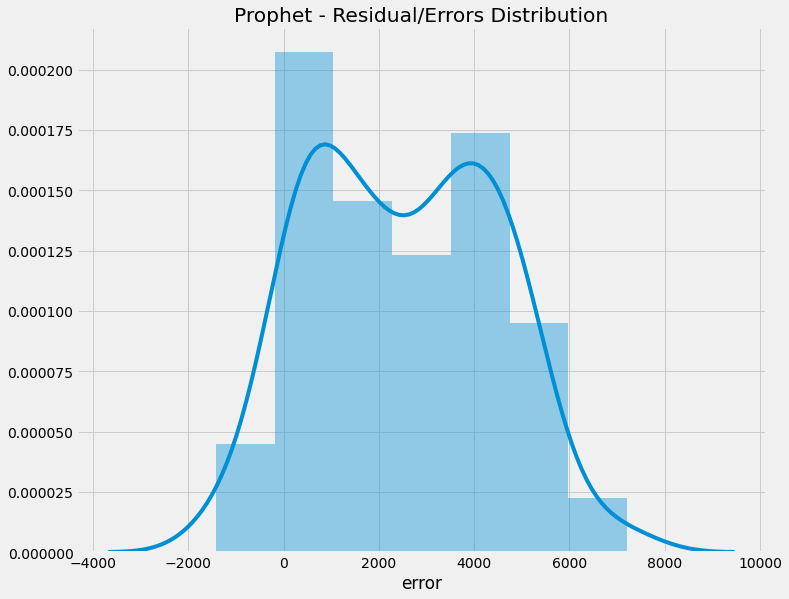

In [173]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(prophet_errors['error'], kde=True);

# Plot Labels, Legends etc
plt.title('Prophet - Residual/Errors Distribution')

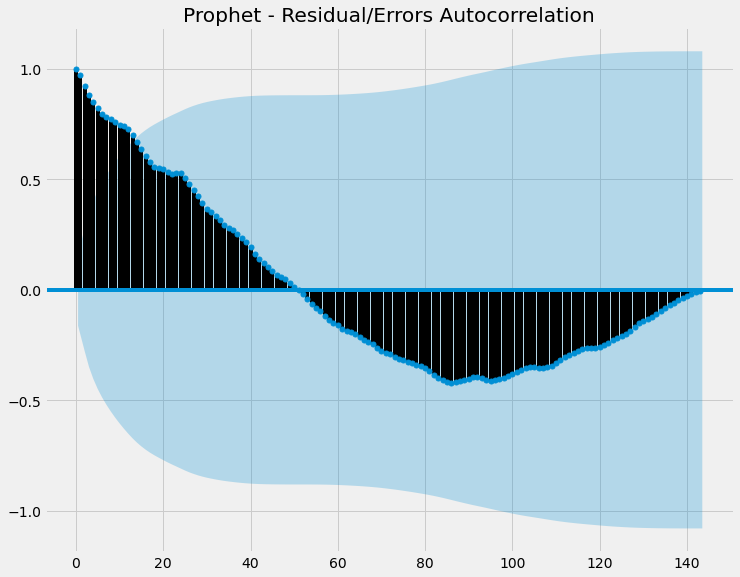

In [174]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(prophet_errors['error'],lags=143) #alpha 1 suppresses CI

plt.title('Prophet - Residual/Errors Autocorrelation')
plt.show()

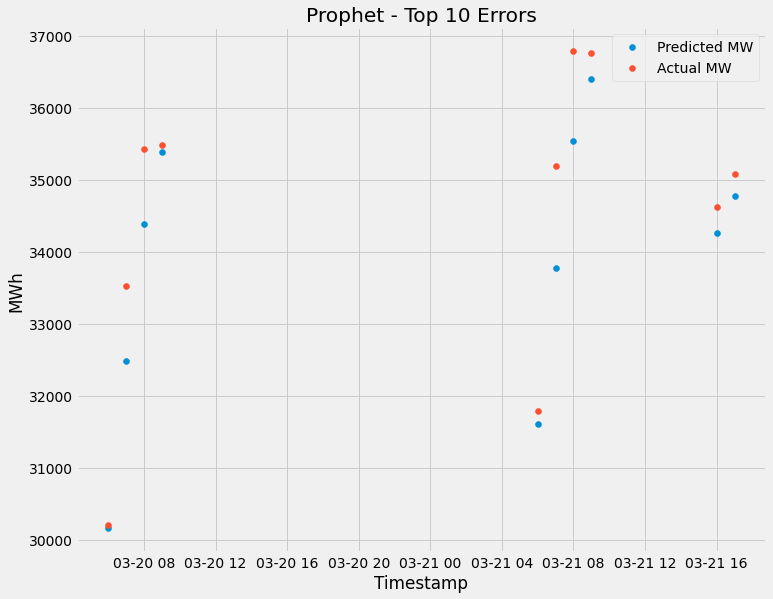

In [175]:
# Let's get the top 10 over forecasts (i.e. where the error is the highest negative number)
top_10_errors = prophet_errors.sort_values('error', ascending=True)[['PJME_MW_ACTUAL', 'PJME_MW', 'error']].head(10)

plt.scatter(top_10_errors.index, top_10_errors['PJME_MW'], label='Predicted MW')
plt.scatter(top_10_errors.index, top_10_errors['PJME_MW_ACTUAL'], label='Actual MW')

# Labels, Titles, etc.
plt.title('Prophet - Top 10 Errors')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

In [176]:
top_10_errors.head(10)

PJME_MW_ACTUAL       PJME_MW        error
ds                                                            
2006-03-21 07:00:00         35197.0  33777.275100 -1419.724900
2006-03-21 08:00:00         36784.0  35532.555644 -1251.444356
2006-03-20 07:00:00         33533.0  32484.892322 -1048.107678
2006-03-20 08:00:00         35434.0  34387.330423 -1046.669577
2006-03-21 09:00:00         36766.0  36400.235192  -365.764808
2006-03-21 16:00:00         34619.0  34265.233049  -353.766951
2006-03-21 17:00:00         35085.0  34769.329826  -315.670174
2006-03-21 06:00:00         31799.0  31611.112773  -187.887227
2006-03-20 09:00:00         35487.0  35391.981781   -95.018219
2006-03-20 06:00:00         30214.0  30162.530641   -51.469359

The most incorrect days were March, 07h and 08h.

# Bringing it all together - the final results

Finally, Let's bring the models together and see which one did the best:

In [188]:
print("MAE HoltWinters: {:.2f}".format(meanabs(test['PJME_MW'], HWES_prediction['PJME_MW'])))
print("MAE LASSO: {:.2f}".format(mean_absolute_error(test_label, LASSO_prediction['PJME_MW'])))
print("MAE SARIMA: {:.2f}".format(meanabs(test['PJME_MW'], SARIMA_prediction['PJME_MW'])))
print("MAE Prophet: {:.2f}".format(meanabs(test['PJME_MW'], PROPHET_prediction['PJME_MW'])))

MAE HoltWinters: 15174.04
MAE LASSO: 4294.53
MAE SARIMA: 3644.16
MAE Prophet: 2590.35


Now let's also look at Mean Absolute Percentage Error (MAPE)

Unlike MAE, MAPE has issues in its calculations, namely when the actual value is 0 (can't divide by zero) and negative values can't go beyond -100%.

Regardless, MAPE is a good 'sense-check' to see which model is proportionally better.

In [178]:
def MAPE(y_true, y_pred): 
    '''Function to calculate MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [189]:
print("MAE HoltWinters: {:.2f}%".format(MAPE(test['PJME_MW'], HWES_prediction['PJME_MW'])))
print("MAE LASSO: {:.2f}%".format(MAPE(test['PJME_MW'], LASSO_prediction['PJME_MW'])))
print("MAE SARIMA: {:.2f}%".format(MAPE(test['PJME_MW'], SARIMA_prediction['PJME_MW'])))
print("MAE Prophet: {:.2f}%".format(MAPE(test['PJME_MW'], PROPHET_prediction['PJME_MW'])))

MAE HoltWinters: 47.62%
MAE LASSO: 12.99%
MAE SARIMA: 10.97%
MAE Prophet: 8.41%


In [180]:
def plot_model_result(ax, prediction, model_name, color):
    '''
    Plot model results.
    
    prediction : DataFrame
    model_name : str
    
    return ax
    '''
    # Training and Test Actuals
    ax.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
    ax.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')

    # Model Results
    ax.plot(prediction['PJME_MW'], label=model_name, color=color, alpha=0.7)
    
    # For clarify, let's limit to only August 2016 onwards
    ax.set_xlim(datetime(2006, 3, 1),datetime(2006, 3, 30))

    # Set Y Axis
    ax.set_ylim(10000, 40000)
    
    # Set Axis labels
    ax.set_ylabel("MWh")
    ax.legend(loc='best')
    ax.set_title(
        "{}: MAPE: {:.2f}% | MAE: {:.2f}".format(
            model_name,MAPE(test["PJME_MW"], prediction["PJME_MW"]),
            mean_absolute_error(test["PJME_MW"], prediction["PJME_MW"])
            )
        , fontsize=40
    )

    return ax

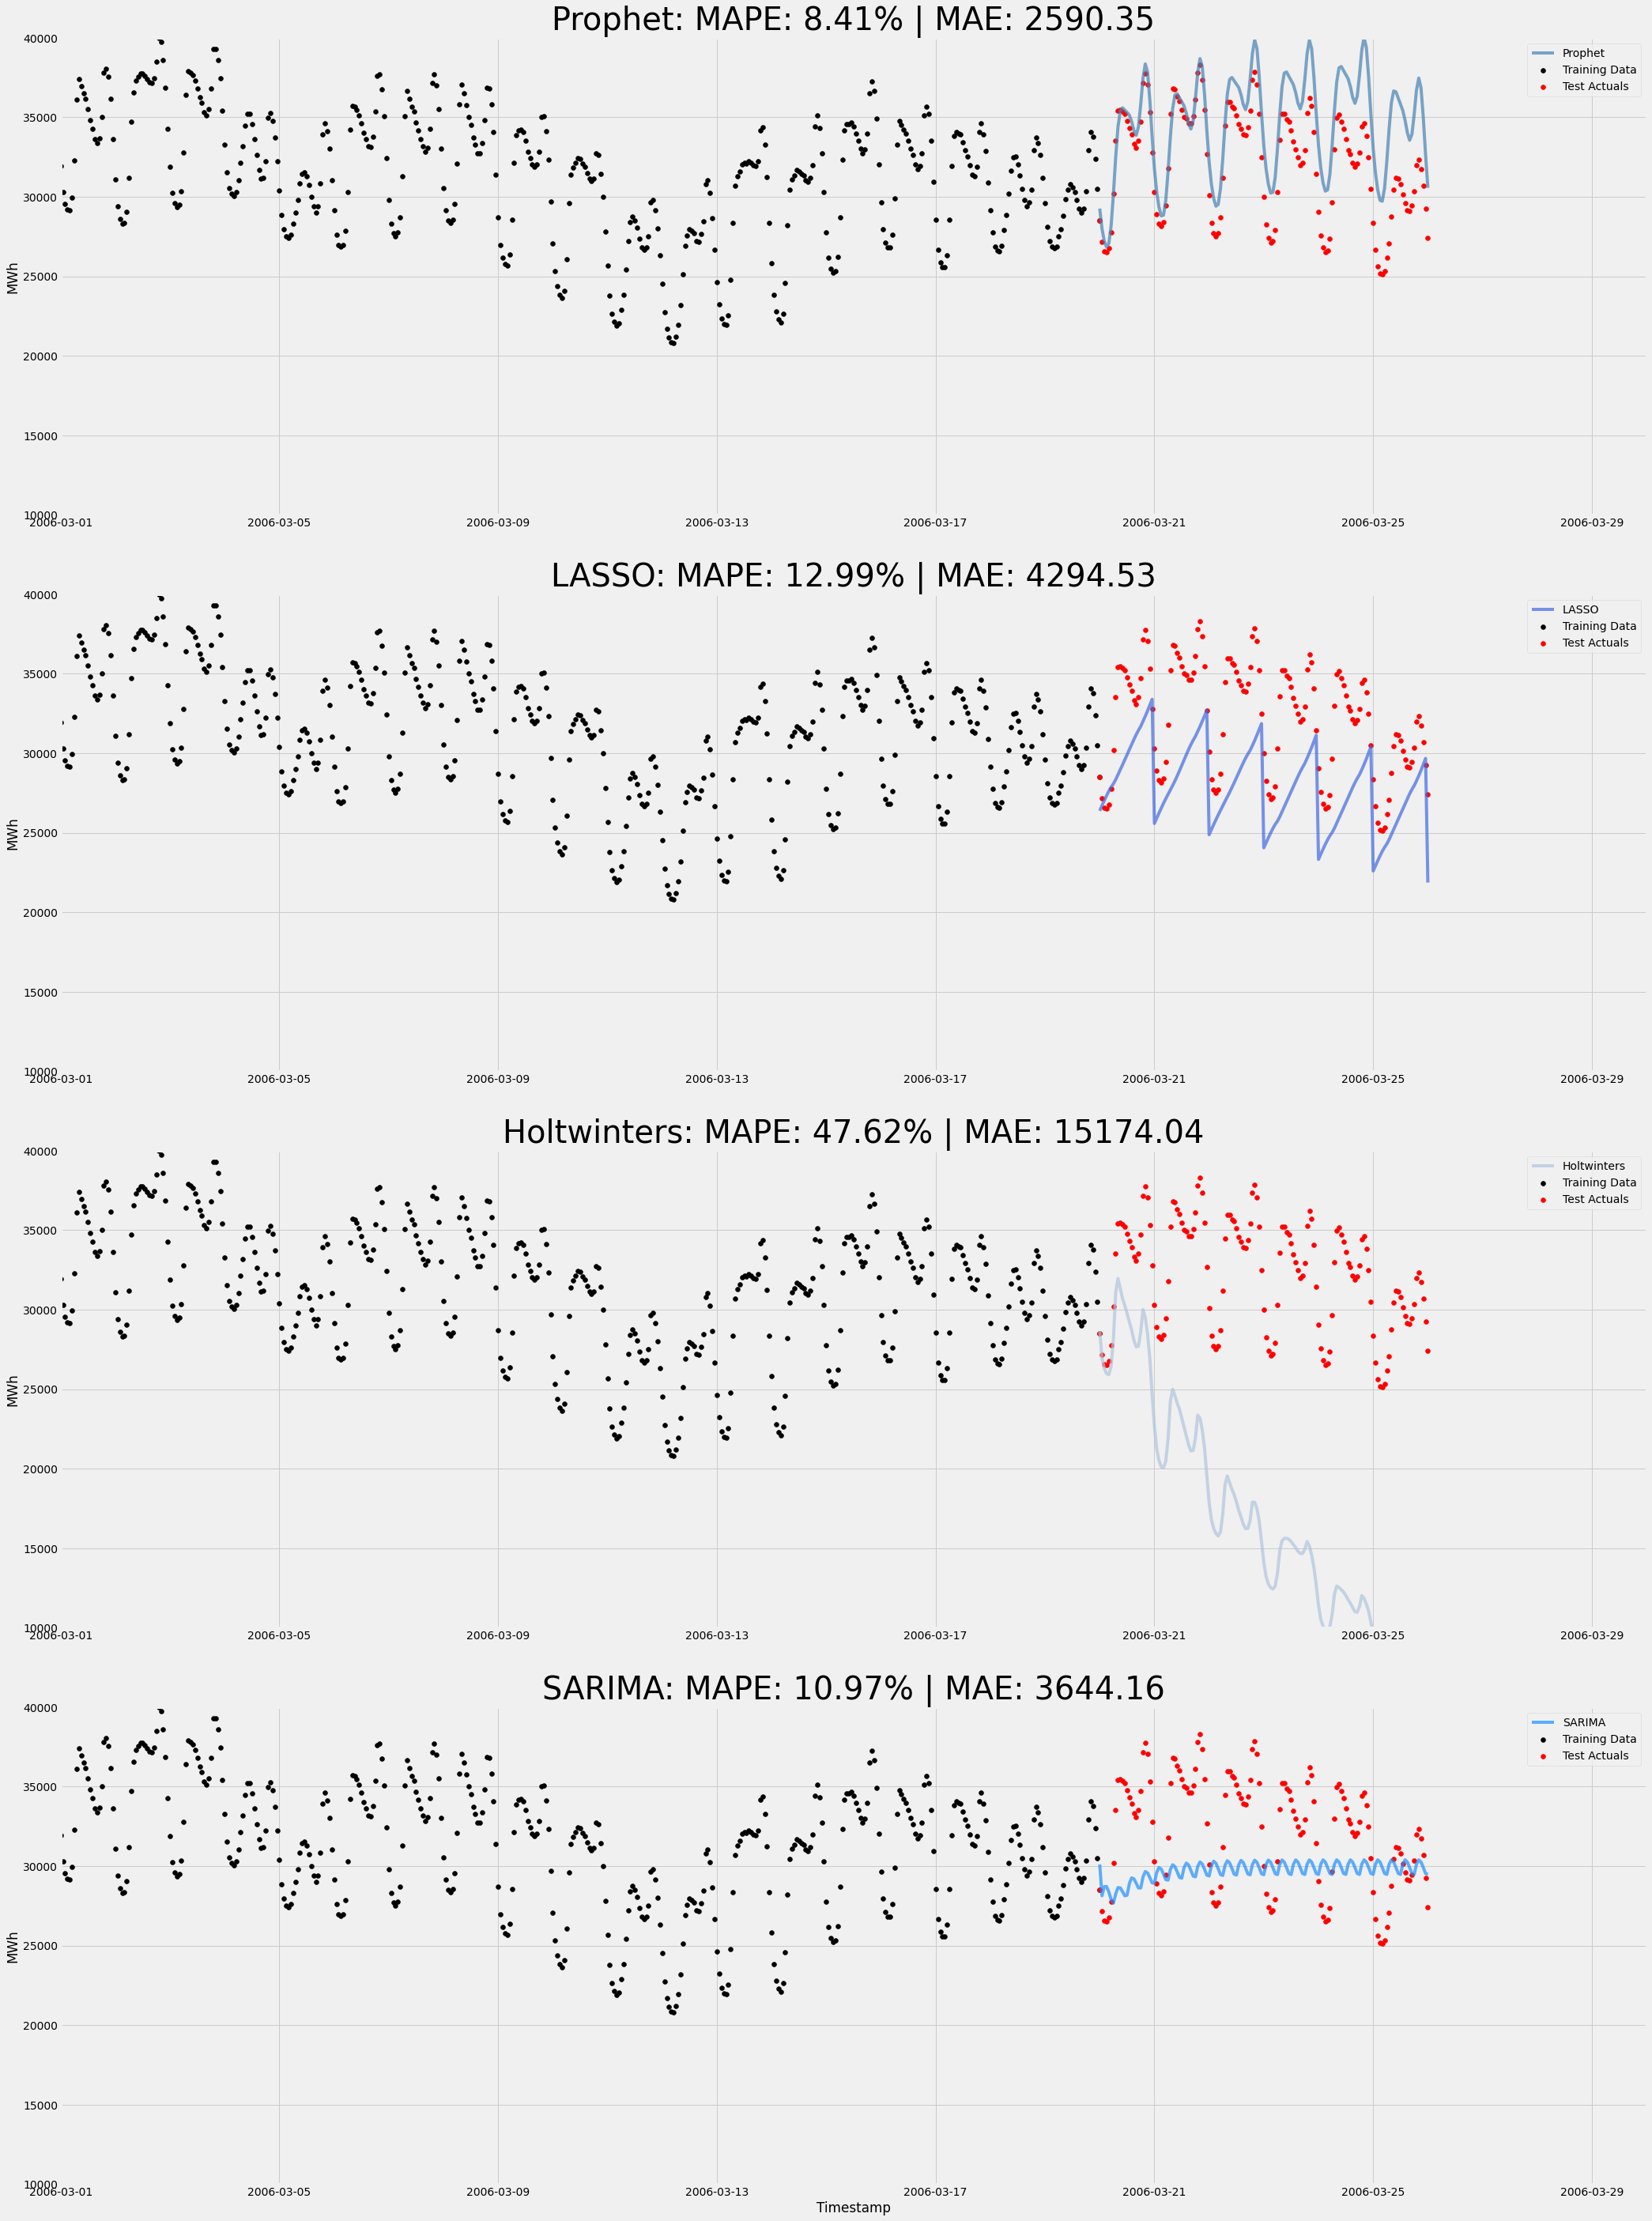

In [192]:
fig, ax = plt.subplots(4,1, figsize=(30,40))

# Plot Labels, Legends etc
plt.xlabel("Timestamp")

ax[0] = plot_model_result(ax[0], PROPHET_prediction, model_name='Prophet', color='steelblue')
ax[1] = plot_model_result(ax[1], LASSO_prediction, model_name='LASSO', color='royalblue')
ax[2] = plot_model_result(ax[2], HWES_prediction, model_name='Holtwinters', color='lightsteelblue')
ax[3] = plot_model_result(ax[3], SARIMA_prediction, model_name='SARIMA', color='dodgerblue')

plt.tight_layout(pad=3.0)
plt.show()

The lower the error the better/more accurate the model is, so therefore in this case, the winner is Phophet! 

You can see that there was a lot of noise in this dataset, more conventional statistical approaches, such as Holtwinters and SARIMA weren't able to get through all that noise.

Interestingly, all the forecasting models beat the baseline, except Holtwinters and SARIMA. This does at least demonstrate that we are still better off using these models than just doing naive forecasting.